In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Finding ring atoms/bonds

In [11]:
from mychem_template import *

In [12]:
m=Molecule.from_smiles("c1occ(NC(F)(F)F)c1N(O)C")
m=Molecule.from_smiles("c1ccccc1c2ccccc2")

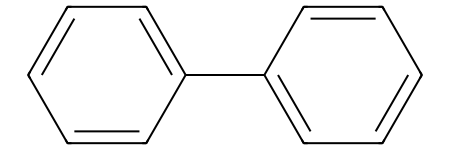

In [13]:
m.to_rdkit()

In [20]:

def dfs(root,path=None,visited=None,ring_atoms=None,ring_bonds=None):
    if path is None:
        path = []
    if visited is None:
        visited = set()
    if ring_atoms is None:
        ring_atoms = set()
    if ring_bonds is None:
        ring_bonds = set()
        
    if root in visited:
        return
    
    if root in path:
        #print(root,path)
        cycle=path[path.index(root):]
        for atom in cycle:
            ring_atoms.add(atom)
        cycle_successor = cycle[1:]+cycle[:1]
        for a,b in zip(cycle,cycle_successor):
            ring_bonds.add(a.get_bond(b))
    else:
        parent = path[-1] if path else None
        path.append(root)
        for nbor in root.get_neighbors():
            if nbor != parent:
                dfs(nbor,path,visited,ring_atoms,ring_bonds)
        path.pop()
    visited.add(root)
    
    return ring_atoms,ring_bonds

In [21]:
#ra,rb=#
dfs(m.get_atoms()[0])

({<mychem_template.Atom at 0x2831c3eea00>,
  <mychem_template.Atom at 0x2831e0005e0>},
 {<mychem_template.Bond at 0x2831c3c6a00>,
  <mychem_template.Bond at 0x2831c3eea90>})

In [17]:
ra,rb=dfs(m.get_atoms()[0])
ra,rb

({<mychem_template.Atom at 0x2831c3eea00>,
  <mychem_template.Atom at 0x2831e0005e0>},
 {<mychem_template.Bond at 0x2831c3c6a00>,
  <mychem_template.Bond at 0x2831c3eea90>})

In [18]:
rbs = set()
from itertools import combinations
for a,b in combinations(ra,2):
        bd=a.get_bond(b)
        
        if bd is not None:
            rbs.add(bd)

In [19]:
rbs

{<mychem_template.Bond at 0x2831c3c6220>,
 <mychem_template.Bond at 0x2831c3eea90>}

In [24]:
def dfss(root,path=None,visited=None,parent=None,ring_atoms=None):
    if visited is None:
        visited=set()
    if path is None:
        path=[]
    if ring_atoms is None:
        ring_atoms = set()
    #print(root)
    visited.add(root)
    path.append(root)
    for nbor in root.get_neighbors():
        if nbor!=parent:
            if nbor not in visited:
                dfss(nbor,path,visited,root,ring_atoms)
            else:
                if nbor in path:
                    ring_atoms.update(path[path.index(nbor):])
    path.pop()
    return ring_atoms

In [26]:
len(dfss(m.get_atoms()[0]))

12

In [ ]:
m.get_atoms()

In [ ]:
class Example:
    
    def __init__(self,h,m,s):
        self._h = h
        self._m = m
        self._s = s
        
    def total_time(self):
        self._in_seconds = self._h*3600 + self._m*60+self._s
        return self._in_seconds

In [ ]:
ex=Example(2,13,45)

In [ ]:
ex._in_seconds

In [ ]:
ex.total_time()

In [ ]:
ex._in_seconds

In [ ]:
class AtomNotFoundError(Exception):
    pass

class Molecule(object):

    def __init__(self):#(self,atom,bond,properties)
        # A molecule consists of a set of atoms ...
        self._atom_set: Set[Atom] = set()
        # ... and a set of bonds
        self._bond_set: Set[Bond] = set()
        # For each bond keep a set of associated bonds
        self._atom_bonds: Dict[Atom,Set[Bond]] = defaultdict(set)
        # This can be used to store properties of a molecule like its name or some other info.
        self.properties: Dict[str,str] = dict()
        # These fields contain all the ring atoms and bonds. They will be calculate on demand
        # They should be updated by calling update_properties() when the molecule changes
        # This could be done "automatically" but this would complicate the code
        self._ring_atoms: Set[Atom] = None
        self._ring_bonds: Set[Bond] = None

        ### How RDKit does it
        #       RDKit is written in C++. The topology is stored as an adjacency list.
        #       Atoms are stored in a vector (Python list-like), and the index to the vector identifies an atom.
        #       For each atom a vector (Python list-like) of Bonds exist.
        #       All bonds are stored in a vector identified by their index.
        #       Here we do not use indices at all, instead atoms are identified by atom objects
        #       and bonds by bond objects
        ###

    ### Accessor methods ###
    def get_num_atoms(self) -> int:
        return len(self._atom_set)

    def get_atoms(self) -> List["Atom"]:
        return list(self._atom_set)

    def get_num_bonds(self) -> int:
        return len(self._atom_set)

    def get_bonds(self) -> List["Bond"]:
        return list(self._bond_set)

    def has_property(self, key: str) -> bool:
        return key in self.properties

    def get_property(self, key: str) -> str:
        return self.properties[key]

    def get_property_keys(self) -> List[str]:
        return list(self.properties.keys())

    def to_rdkit_with_map(self) -> Tuple[rdkit.Chem.RWMol, Dict["Atom", int]]:
        """
        Convert this molecule to an RDKit molecule
        :return (mol,map): mol tis the RDKit molecule and map is a map mapping Molecule Atom objects to RDKit atom indices
        """
        rwmol = rdkit.Chem.RWMol()  # Empty "editable" molecules
        # Dict for mapping "Atom"s to RDKit atom indices, needed for adding bonds
        atom_dict: Dict["Atom", int] = {}
        for a in self.get_atoms():
            # For each atom a:
            # Create new RDKit atom
            idx = rwmol.AddAtom(rdkit.Chem.Atom(a.get_atomic_number()))
            # ... add to RDKit molecule
            atom: rdkit.Chem.Atom = rwmol.GetAtomWithIdx(idx)
            # ... add correct number of hydrogens & formal charge
            atom.SetNoImplicit(True)
            atom.SetNumExplicitHs(a.get_hydrogen_count())
            atom.SetFormalCharge(a.get_formal_charge())
            atom_dict[a] = idx
        for b in self.get_bonds():
            # look up corresponding RDKit bond type
            bt = rdkit.Chem.BondType.values[
                int(b.get_order())] if b.get_order() != 1.5 else rdkit.Chem.BondType.AROMATIC
            # Add bond by looking up the RDKit atom indices for the bond
            rwmol.AddBond(atom_dict[b.get_first()], atom_dict[b.get_second()], bt)
        # Update properties of the molecule
        # E.g., If we had not used
        #     atom.SetNoImplicit(True)
        #     atom.SetNumExplicitHs(a.get_hydrogen_count())
        # this function would automatically add implicit hydrogens to the RDKit atoms to match the valences.
        rwmol.UpdatePropertyCache()
        return rwmol, atom_dict

    def to_rdkit(self) -> rdkit.Chem.RWMol:
        """
        Convert this molecule to an RDKit molecule
        :return:
        """
        rwmol, _ = self.to_rdkit_with_map()
        return rwmol

    def to_smiles(self) -> str:
        """
        For output we are going to "cheat". We first convert our Molecule object to an RDKit molecule and use its
        Smiles generation function
        :return: Smiles
        """
        rdmol = self.to_rdkit()
        return rdkit.Chem.MolToSmiles(rdmol)

    ### Modification methods ###

    def add_atom(self, atomic_num: int, hydrogen_count: int=0, formal_charge: int=0) -> "Atom":
        atom = Atom(self, atomic_num, hydrogen_count, formal_charge)
        self._atom_set.add(atom)
        return atom

    def remove_atom(self, atom: "Atom") -> bool:
        """
        Remove an atom and all associated bonds
        :param atom:
        :return: True if atom could be removed, False if atom does not exist
        """
        if atom in self._atom_set:
            for bond in list(self._atom_bonds[atom]): # Use copy as _atom_bonds[atom] will be modified
                self.remove_bond(bond)
            del self._atom_bonds[atom]
            self._atom_set.remove(atom)
            return True
        else:
            return False

    def add_bond(self, first, second, order) -> Optional["Bond"]:
        if second in first.get_neighbors():
            # return None if the bond already exists
            return None
        bond = Bond(self, first, second, order)
        # Add bond to set of bonds
        self._bond_set.add(bond)
        # ... and add to set of bonds for each of its atoms
        self._atom_bonds[bond.get_first()].add(bond)
        self._atom_bonds[bond.get_second()].add(bond)
        return bond

    def remove_bond(self, bond) -> bool:
        if bond in self._bond_set:
            # Remove from bond set
            self._bond_set.remove(bond)
            # and remove from atom bond sets
            self._atom_bonds[bond.get_first()].remove(bond)
            self._atom_bonds[bond.get_second()].remove(bond)
            return True
        else:
            return False

    def is_in_ring(self, atom_or_bond):
        if isinstance(atom_or_bond, Atom):
            return atom_or_bond in self._ring_atoms
        else:
            return atom_or_bond in self._ring_bonds

    def update_properties(self):
        # If a Molecule changes one should call update_properties to update
        # properties dependent on the structure. These might include
        # whether atoms/bonds are in rings or aromaticity perception
        # For now the method will only update ring membership
        self.determine_rings()
#--------------------------------------------------------------------------task - 4
    def get_molecular_weight(self)->int:
        pass
#--------------------------------------------------------------------------------------------------task - 5

#     def get_connectivity_index_0(self,mol)->int:
#         # TODO: See Handout 2, exercise 5
#         total = 0
#         for a in mol.get_atoms():# or? # for a in self._atom_set.get_atoms()
#             d = a.get_degree()
#             total += 1/sqrt(d)
#         return total
#-----------------------------------------------------------------    
    def get_connectivity_index_0(self)->float:# TODO: See Handout 2, exercise 5
        pass
#------------------------------------------------------------------

    def get_connectivity_index_1(self)->float:# TODO: See Handout 2, exercise 5
        pass

    def get_connectivity_index_2(self)->float:# TODO: See Handout 2, exercise 5
        pass
#--------------------------------------------------------------------------------------- task-6       

    def _get_number_of_paths_of_length2(self):
        # TODO: See Handout 2, exercise 6
        total2=0
        for a in self.get_atoms():
            for b in a.get_neighbors():
                for c in b.get_neighbors():
                    if a.GetIdx()!=c.GetIdx(): # a!=c
                        total2 += 1
        return total2
        
        

    def _get_number_of_paths_of_length3(self):
        # TODO: See Handout 2, exercise 6
        total2=0
        for middle_bond in self.get_bonds():
            left_middle_atom = middle_bond.get_first()
            right_middle_atom = middle_bond.get_second()
            left_neighbors = [a for a in left_middle_atom.get_neighbors(self) 
                              if a.GetIdx()!=right_middle_atom.GetIdx()]
            right_neighbors = [a for a in right_middle_atom.get_neighbors(self) 
                              if a.GetIdx()!=left_middle_atom.GetIdx()]
            for left_atom,right_atom in product(left_neighbors,right_neighbors):
                total2 += 1
        return total2
        
        
#----------------------------------------------------------------

    def get_kier_1(self):
        # TODO: See Handout 2, exercise 6
         #total = 0
         #for b in self.GetBonds():
             #d1=b.GetBeginAtom().GetDegree()
             #d2=b.GetEndAtom().GetDegree()
             #total += 1
         #total2 = 0
        
        #------------------------------ todo
        n=self.get_num_atoms()
        kier_1=(n(n-1)**2)/(total)**2
        return kier_1
#----------------------------------------------------------------
        
        

    def get_kier_2(self):
        # TODO: See Handout 2, exercise 6
#         total2=0
#         for a in self.GetAtoms():
#             for b in a.GetNeighbors():
#                 for c in b.GetNeighbors():
#                     if a.GetIdx()!=c.GetIdx(): # a!=c
#                         total2 += 1
        total2=self.get_num_atoms()
        total1=0
        for middle_atom in self.get_atoms():
            # from combinations we get the possiblity of having two...
            for begin_atom,end_atom in combinations(middle_atom.get_neighbors(),2):
                d1,d2,d3=(begin_atom.get_degree(),middle_atom.get_degree(),end_atom.get_degree())
                total1 += 1
        kier_2=(((total2//2)-1)*((total2//2)-2)**2)/(total1)**2
        return kier_2
#------------------------------------------------------------------

    def get_kier_3(self):
#         total2=0
#         for middle_bond in self.GetBonds():
#             left_middle_atom = middle_bond.GetBeginAtom()
#             right_middle_atom = middle_bond.GetEndAtom()
#             left_neighbors = [a for a in left_middle_atom.GetNeighbors() 
#                               if a.GetIdx()!=right_middle_atom.GetIdx()]
#             right_neighbors = [a for a in right_middle_atom.GetNeighbors() 
#                               if a.GetIdx()!=left_middle_atom.GetIdx()]
#             for left_atom,right_atom in product(left_neighbors,right_neighbors):
#                 total2 += 1
        total2=self.get_num_atoms()
                
        # todo for total1
        if total2/2!=0:# if its odd 
            kier_3=((total2-1)-(total2-3)**2)/()
        else:
            kier_3=((total2-3)-(total2-2)**2)/()
            
        
        
#------------------------------------------------------------------

    def determine_rings(self):
        # TODO: See Handout 2, exercise 7
        #       Implement this method by deteriming all ring atoms and bonds storing them as sets in
        #       self._ring_atoms and self._ring_bonds
        

    @staticmethod
    def empty() -> "Molecule":
        return Molecule()

    @staticmethod
    def from_rdkit(rdmol) -> "Molecule":
        mol = Molecule.empty()
        atoms = {} # Map RDKit atom index to Molecule Atom object
        for a in rdmol.GetAtoms():
            atom = mol.add_atom(a.GetAtomicNum(), a.GetTotalNumHs(), a.GetFormalCharge())
            atoms[a.GetIdx()] = atom
        for b in rdmol.GetBonds():
            mol.add_bond(atoms[b.GetBeginAtomIdx()], atoms[b.GetEndAtomIdx()], b.GetBondTypeAsDouble())
        mol.update_properties()
        return mol

    @staticmethod
    def from_smiles(smiles) -> "Molecule":
        rdmol = rdkit.Chem.MolFromSmiles(smiles)
        return Molecule.from_rdkit(rdmol)

class Atom(object):

    def __init__(self, mol: Molecule, atomic_number: int, hydrogen_count: int, formal_charge: int):
        self._mol = mol
        self._atomic_number = atomic_number
        self._hydrogen_count = hydrogen_count
        self._formal_charge = formal_charge

    def get_atomic_number(self) -> int:
        return self._atomic_number

    def get_atomic_symbol(self) -> str:
        return GetPeriodicTable().GetElementSymbol(self._atomic_number)

    def get_hydrogen_count(self) -> int:
        """
        :return: number of (implicitly) attached hydrogens
        """
        return self._hydrogen_count

    def is_aromatic(self) -> bool:
        return any(map(lambda x: x.is_aromatic(), self.get_bonds()))

    def is_in_ring(self) -> bool:
        return self._mol.is_in_ring(self)

    def get_formal_charge(self) -> int:
        return self._formal_charge

    def get_bond(self, other: "Atom") -> "Bond":
        """
        :param other:
        :return: Bond between self and other if it exists else None
        """
        assert other != self
        for bond in self.get_bonds():
            if bond.get_first() == other or bond.get_second() == other:
                return bond
        return None

    def get_bonds(self) -> List["Bond"]:
        """
        :return: Bonds of this atom
        """
        return list(self._mol._atom_bonds[self])

    def get_neighbors(self) -> List["Atom"]:
        """
        :return: neighboring atoms
        """
        return [bond.get_other(self) for bond in self._mol._atom_bonds[self]]

    def get_degree(self) -> int:
        """
        :return: the number of neighboring atoms (excluding implicit hydrogens)
        """
        return len(self._mol._atom_bonds[self])

    def set_atomic_number(self, atomic_number: int):
        self._atomic_number = atomic_number

    def set_hydrogen_count(self, hydrogen_count: int):
        self._hydrogen_count = hydrogen_count

    def set_formal_charge(self, formal_charge: int):
        self._formal_charge = formal_charge


class Bond(object):
    def __init__(self, mol, first_atom: Atom, second_atom: Atom, order: float):
        self._mol = mol
        self._first = first_atom
        self._second = second_atom
        if id(self._second) < id(self._first):
            # This ensures that atoms are stored in a well defined order.
            self._first, self._second = self._second, self._first
        self._order = order

    def get_order(self) -> float:
        return self._order

    def is_aromatic(self) -> bool:
        return self.get_order() == 1.5

    def is_in_ring(self) -> bool:
        return self._mol.is_in_ring(self)

    def get_first(self) -> Atom:
        return self._first

    def get_second(self) -> Atom:
        return self._second

    def get_other(self, atom) -> Atom:
        """
        :param atom: one atom of the bond
        :return: the other atom of the bond
        """
        if self._first == atom:
            return self._second
        if self._second == atom:
            return self._first
        return None

    def set_order(self, order: float):
        self._order = order


In [ ]:
mol = Molecule.from_smiles("Clc3ccccc3C2=NC(O)C(=O)Nc1c2cc(Cl)cc1")
for i,atom in enumerate(mol.get_atoms()):
    print("Atom # {} is a {} with {} neighbors".format(
        i,atom.get_atomic_symbol(),atom.get_degree()))